In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tsfel as ts

**Coding an Autoencoder to try to compress extracted temporal features into encodings to be used as static variables in TFT**

In [2]:
data = pd.read_csv('../data/data_processed_plant_item_10_03_22.csv')

In [3]:
def scaler_func(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.to_numpy())
    return scaled_data


def feature_engineering(data):
    # Extract features
    data = data[data['time_idx'] < 29]
    #data = data[data['time_idx'] >= 6]
    vol = pd.DataFrame(data['Volume'])
    cfg_file = ts.get_features_by_domain("temporal")
    #cfg_file = ts.get_features_by_domain()
    X = ts.time_series_features_extractor(cfg_file, vol, window_size=29)
    return X


def AE_data_creator(data):
    feature_data = feature_engineering(data)
    print(feature_data)
    feature_data_scaled = scaler_func(feature_data)
    print(feature_data_scaled.shape)
    ts_list = list(data.timeseries.unique())
    AE_data = np.zeros((len(ts_list), feature_data.shape[1] + 1))
    for i in range(len(ts_list)):
        ts_num = ts_list[i]
        ts_vol = np.array(data[data.timeseries == ts_num].Volume)
        ts_vol_fut = ts_vol[-6::]
        num_non_zeros = len(ts_vol_fut[ts_vol_fut != 0])
        AE_data[i, 0:feature_data_scaled.shape[1]] = feature_data_scaled[i, :]
        #AE_data[i, -1] = sum(ts_vol_fut)
        AE_data[i, -1] = num_non_zeros
    return AE_data, feature_data   


AE_data, feature_data = AE_data_creator(data)

*** Feature extraction started ***


C:\Users\JOSEPH~1.AME\AppData\Local\Temp/ipykernel_20436/2064394654.py:14: UserWarning: Using default sampling frequency set in configuration file.
  X = ts.time_series_features_extractor(cfg_file, vol, window_size=29)



*** Feature extraction finished ***
       0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0               608073.0                  24.330           608073.0   
1                32353.0                   4.880            32353.0   
2                69131.0                   6.320            69131.0   
3               343302.0                  18.200           343302.0   
4                  215.0                   0.230              215.0   
...                  ...                     ...                ...   
10446               12.0                   0.050               12.0   
10447               20.0                   0.060               20.0   
10448                4.0                   0.010                4.0   
10449              149.0                   0.275              149.0   
10450                0.0                   0.000                0.0   

       0_Centroid  0_Entropy  0_Mean absolute diff  0_Mean diff  \
0        0.155397   0.750008             71

In [4]:
pd.DataFrame.to_csv(feature_data, '../data/temporal_feature_set')

In [5]:
print(AE_data.shape)

(10451, 19)


In [6]:
#Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(np.shape(AE_data)[1] - 1, 20),
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 20),
            nn.Tanh(),
            nn.Linear(20, np.shape(AE_data)[1] - 1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Train model
torch.manual_seed(42)
AE = Autoencoder()
running_loss = 0
batchSize = 100
maxEpochs = 100
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(AE.parameters(), lr=0.005)
optimiser.zero_grad()
trainloader_NN = torch.utils.data.DataLoader(AE_data, batch_size=batchSize, shuffle=True)
losses_NN = []
epochs_NN = []
for epoch in range(1, maxEpochs + 1):
    for batch in trainloader_NN:
        optimiser.zero_grad()
        features = batch[:, 0:-1]
        feature_preds = AE(features.float())
        loss = criterion(feature_preds, features.float())
        loss.backward()
        optimiser.step()
        loss = loss.item()
        running_loss += loss
    average_loss = (running_loss / (AE_data.shape[0] / batchSize))
    print('Loss at epoch', epoch, 'is', average_loss)
    losses_NN.append(average_loss)
    epochs_NN.append(epoch)
    running_loss = 0

Loss at epoch 1 is 0.714004379606694
Loss at epoch 2 is 0.4794647446455265
Loss at epoch 3 is 0.4223608490713771
Loss at epoch 4 is 0.3958681187137167
Loss at epoch 5 is 0.38305690034235873
Loss at epoch 6 is 0.3644467165807527
Loss at epoch 7 is 0.34272008277949917
Loss at epoch 8 is 0.33078352065134725
Loss at epoch 9 is 0.3205333443298122
Loss at epoch 10 is 0.2974207053477314
Loss at epoch 11 is 0.2760770293573776
Loss at epoch 12 is 0.24947822571610642
Loss at epoch 13 is 0.26607644702245054
Loss at epoch 14 is 0.2429221484515327
Loss at epoch 15 is 0.2220242039444241
Loss at epoch 16 is 0.210937563910597
Loss at epoch 17 is 0.20714145470647627
Loss at epoch 18 is 0.19876996901643046
Loss at epoch 19 is 0.19123141095363036
Loss at epoch 20 is 0.1903748938371982
Loss at epoch 21 is 0.18206355770162824
Loss at epoch 22 is 0.180096134868504
Loss at epoch 23 is 0.17181894657383945
Loss at epoch 24 is 0.1672581235113845
Loss at epoch 25 is 0.16543599767566763
Loss at epoch 26 is 0.1640

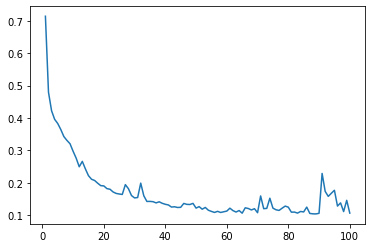

In [8]:
plt.plot(epochs_NN, losses_NN)
plt.show()

In [9]:
#Encode data with trained encoder and attached column to use for colour coding
def encode_and_compare(data):
    past_vols = data[:, 0:-1]
    print('Size of scaled dataset:', np.shape(past_vols))
    torch_array = torch.from_numpy(past_vols).float()
    encoded_data = AE.encoder(torch_array).detach()
    num_zeros = np.reshape(data[:, -1], (data.shape[0], 1))
    complete_data = np.append(encoded_data, num_zeros, axis=1)
    print('Size of encoded dataset:', np.shape(complete_data))
    return complete_data


complete_data = encode_and_compare(AE_data)

Size of scaled dataset: (10451, 18)
Size of encoded dataset: (10451, 3)


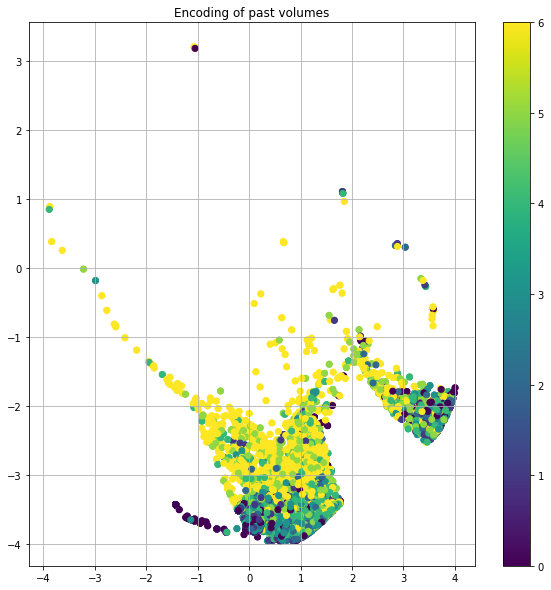

In [12]:
def plot_encodings(data):
    #data = data[data[:, 1] < -1]
    #data = data[data[:, -1] < 3]
    #data2 = data[data[:, -1] >= 3]
    #data = data[data[:, 0] < 0]
    #data = data[data[:, 1] < 0]
    plt.figure(figsize=(10, 10))
    plt.grid()
    plt.title('Encoding of past volumes')
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])
    plt.colorbar()
    plt.show()

plot_encodings(complete_data)

In [51]:
encodings = complete_data[:, 0:-1]
print(encodings.shape)
np.save('../data/temporal_encodings', encodings)

(10451, 3)
